# **In-Class Assignment: Document Clustering**

## *DATA 5420/6420*
## Name: Dallin Moore

In this in-class assignment we will utilize the same `TMDB movies dataset` as we did in the previous activity, however, we will now group movies together based off of different clustering methods. We will examine the pros and cons of these different methods and consider the different ways that they group together movies of similar taglines and overviews.

We begin as always by loading our required dependencies, loading in the dataset, and performing some cleaning/preporcessing steps.

In [2]:
import pandas as pd
import nltk
import re
import numpy as np

nltk.download('stopwords')
nltk.download('punkt')

!pip install kneed
from kneed import KneeLocator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation

from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
df = pd.read_csv("/content/tmdb_5000_movies.csv") # read in dataset
df.info() # check for missing observations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4802 non-null   int64  
 1   genres                4802 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4802 non-null   int64  
 4   keywords              4802 non-null   object 
 5   original_language     4802 non-null   object 
 6   original_title        4802 non-null   object 
 7   overview              4799 non-null   object 
 8   popularity            4802 non-null   float64
 9   production_companies  4802 non-null   object 
 10  production_countries  4802 non-null   object 
 11  release_date          4801 non-null   object 
 12  revenue               4802 non-null   int64  
 13  runtime               4800 non-null   float64
 14  spoken_languages      4802 non-null   object 
 15  status               

In [4]:
df = df[['title', 'tagline', 'overview', 'genres', 'popularity']]
df.tagline.fillna('', inplace=True)
df['description'] = df['tagline'].map(str) + ' ' + df['overview']
df.dropna(inplace=True)

<ipython-input-4-26d2589c0cc6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.tagline.fillna('', inplace=True)
<ipython-input-4-26d2589c0cc6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['tagline'].map(str) + ' ' + df['overview']
<ipython-input-4-26d2589c0cc6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [5]:
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)                                       # lower case and remove special characters\whitespaces
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)                                                          # tokenize document
    filtered_tokens = [token for token in tokens if token not in stop_words]                  # filter stopwords out of document
    doc = ' '.join(filtered_tokens)                                                           # re-create document from filtered tokens
    return doc

normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(df['description']))
len(norm_corpus)

4799

In [6]:
norm_corpus[0:3]

array(['enter world pandora 22nd century paraplegic marine dispatched moon pandora unique mission becomes torn following orders protecting alien civilization',
       'end world adventure begins captain barbossa long believed dead come back life headed edge earth turner elizabeth swann nothing quite seems',
       'plan one escapes cryptic message bonds past sends trail uncover sinister organization battles political forces keep secret service alive bond peels back layers deceit reveal terrible truth behind spectre'],
      dtype='<U803')

## **1) Cluster Similar Movies - K-Means Clustering Analysis**

We first begin with clustering movies via KMeans, a type of partition-based clustering. The pipeline for performing this analysis includes:

* Feature Engineering
* Clustering using Kmeans algorithm
* Find an optimal value for K
* Preparing movie clusters

Similarity analysis was one way of grouping together movies, clustering analysis serves as a different approach. Let's see how these methods differ...

> ### **A) Feature Engineering - TF-IDF**

In [7]:
stop_words = stop_words + ['one', 'two', 'get']
tv = TfidfVectorizer(ngram_range=(2,2), min_df=2, max_df=0.7, stop_words=stop_words) # apply countvectorizer to norm_corpus, unigrams and bigrams, min_df = 10, max_df = 0.80
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix.shape

(4799, 8710)

**Let's talk through some of these parameters in our TfidfVectorizer method...**

Because movie descriptions contain lots of bigrams that describe the plot (ex. 'high school'), we will just focus of bigrams to keep the nubmer of features lower. For this dataset, 'one', 'two', and 'get' are all common stop words not included in our normal stop words list, so they will be added.

> ### **B) Clustering using KMeans**

K must be user defined, and it can be difficult to know where to start in terms of the number of clusters. We'll try k = 3 first, then utilize a more empirical method of determining the optimal number of clusters.

In [8]:
km = KMeans(n_clusters=3,
            max_iter=10000,
            n_init= 50,
            random_state = 42).fit(tv_matrix)
Counter(km.labels_)

Counter({0: 4629, 2: 72, 1: 98})

**What is the distribution of movie clusters looking like?**

With 3 clusters, the first cluster contains a lot of the movies, arguably too many. To even them out we will probably just need to increase the number of clusters, which will find using the elbow rule.

> ### **C) Find the optimal value for K - Elbow rule**

We started off with 6 clusters, but perhaps there is a more optimal number. Let's examine a range of k values and use the Elbow rule method using the `KneeLocator` method to guide our selection of k.

In [9]:
kmeans_kwargs = {       # create a kmeans initialization dictionary
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

sse = []                # create empty list for SSE values
for k in range(1,11):   # create loop to fit kmeans clustering analysis of k of size 1-11, add SSE values for each model to the list
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  kmeans.fit(tv_matrix)
  sse.append(kmeans.inertia_)

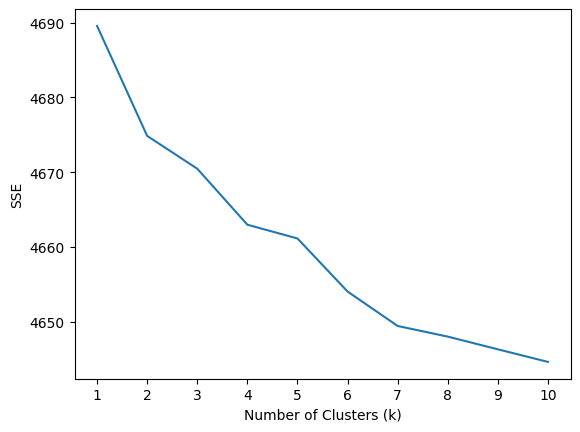

In [10]:
# create elbow plot
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")
plt.show()

In [12]:
kl = KneeLocator(range(1,11), sse, curve = 'convex', direction = 'decreasing')
kl.elbow

6

Now let's rerun our Kmeans with the optimal number of clusters...

In [15]:
km = KMeans(n_clusters=6,
            max_iter=10000,
            n_init= 50,
            random_state = 42).fit(tv_matrix)
Counter(km.labels_)

Counter({0: 4260, 5: 191, 1: 180, 2: 104, 3: 15, 4: 49})

> ### **D) Prepare Movie Clusters**

Now let's get an idea of the characteristics of each cluster by pulling popular examples of movies within each of the clusters...

In [16]:
df['kmeans_cluster'] = km.labels_                                                   # assign cluster labels to new column in df

movie_clusters = (df[['title', 'kmeans_cluster', 'popularity']]                     # great a movie clusters df from title, cluster, and popularity
                  .sort_values(by=['kmeans_cluster', 'popularity'],                 # sort in descending order of cluster and popularity
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))                              # group by cluster, show top 20 movies
movie_clusters = movie_clusters.copy(deep=True)
movie_clusters

,title,kmeans_cluster,popularity
238,Teenage Mutant Ninja Turtles,5,143.350376
362,Pixels,5,140.849495
2731,The Godfather: Part II,5,105.792936
298,The Wolf of Wall Street,5,95.007934
1366,The Devil Wears Prada,5,83.893257
...,...,...,...
124,Frozen,0,165.125366
9,Batman v Superman: Dawn of Justice,0,155.790452
0,Avatar,0,150.437577
662,Fight Club,0,146.757391


In [17]:
feature_names = tv.get_feature_names_out()
topn_features = 15
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]


for cluster_num in range(0,6):
    key_features = [feature_names[index]
                        for index in ordered_centroids[cluster_num, :topn_features]]
    movies = movie_clusters[movie_clusters['kmeans_cluster'] == cluster_num]['title'].values.tolist()
    print('CLUSTER #'+str(cluster_num+1))
    print('Key Features:', key_features)
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #1
Key Features: ['world war', 'small town', 'young man', 'best friend', 'young woman', 'war ii', 'united states', 'along way', 'tells story', 'years later', 'serial killer', 'find way', 'young boy', 'fbi agent', 'love story']
Popular Movies: ['Minions', 'Interstellar', 'Deadpool', 'Guardians of the Galaxy', 'Mad Max: Fury Road', 'Jurassic World', 'Pirates of the Caribbean: The Curse of the Black Pearl', 'Dawn of the Planet of the Apes', 'The Hunger Games: Mockingjay - Part 1', 'Big Hero 6', 'Captain America: Civil War', 'Whiplash', 'The Dark Knight', 'The Martian', 'Inception', 'Frozen', 'Batman v Superman: Dawn of Justice', 'Avatar', 'Fight Club', "Pirates of the Caribbean: Dead Man's Chest"]
--------------------------------------------------------------------------------
CLUSTER #2
Key Features: ['high school', 'los angeles', 'school seniors', 'school student', 'best friend', 'angeles police', 'school senior', 'school students', 'best friends', 'inner city', 'city los', 'sch

**How might you (briefly) describe each of these clusters based on their key features and the top popular movies within them?**

* Cluster 1: Blockbusters Action Films
* Cluster 2: High School Drama
* Cluster 3: True Story Drama
* Cluster 4: Epic Adventures
* Cluster 5: Romantic & Whimsical
* Cluster 6: New York City Life


## **2) Affinity Propagation**

Now let's try out a different clustering method, affinity propagation. Remember that this method does not require the user to specify the number of clusters; it does this automatically by finding exemplar observations that can well represent other data points in their cluster.

Because affinity propagation can often lead to the creation of many clusters, we will only examine the top 10 most common (largest) clusters...

> ### **A) First we will convert our tv_matrix into consine similarity values**

In [18]:
# get cosine similarity features from tv_matrix
cosine_sim_features = cosine_similarity(tv_matrix)

> ### **B) Fit the Model to the features**

Keep in mind that one of the downsides of Affinity Propagation is that its computationally expensive, so it runs pretty slow. It took mine over 2 minutes to execute.

In [19]:
# fit affinity propagation for 1000 iterations
%%time
ap = AffinityPropagation(max_iter=500)
ap.fit(cosine_sim_features)
res = Counter(ap.labels_)
res.most_common(10)

CPU times: user 2min 28s, sys: 2.15 s, total: 2min 30s
Wall time: 2min 47s


[(3, 3858),
 (34, 50),
 (117, 28),
 (98, 27),
 (119, 26),
 (144, 23),
 (64, 18),
 (58, 18),
 (112, 17),
 (60, 16)]

**Wow that's a lot of different clusters! How might this impact the interpretability/usefulness of the clustering analysis? Are there benefits to having a larger number of small clusters vs. a small number of large clusters?**

For this dataset and how we are using it (labeling the clusters ourselves, etc.), fewer clusters is definitely advantageous. However, if we just wanted to recommend a group of movies to watch after watching one movie, this could be useful. The clusters would be smaller and the movies more similar making it better to recommend the whole cluster.

> ### **C) Produce the most popular movies per top 10 clusters**

In [20]:
df['affprop_cluster'] = ap.labels_
filtered_clusters = [item[0] for item in res.most_common(8)] # top 8 most common clusters
filtered_df = df[df['affprop_cluster'].isin(filtered_clusters)]
movie_clusters = (filtered_df[['title', 'affprop_cluster', 'popularity']]
                  .sort_values(by=['affprop_cluster', 'popularity'],
                               ascending=False)
                  .groupby('affprop_cluster').head(20))
movie_clusters = movie_clusters.copy(deep=True)

# get exemplars
exemplars = df.loc[ap.cluster_centers_indices_]['title'].values.tolist() # the top movies for each cluster

# get movies belonging to each cluster
for cluster_num in filtered_clusters:
    movies = movie_clusters[movie_clusters['affprop_cluster'] == cluster_num]['title'].values.tolist()
    exemplar_movie = df[df.index == ap.cluster_centers_indices_[cluster_num]]['title'].values[0]
    print('CLUSTER #'+str(cluster_num))
    print('Exemplar:', exemplar_movie)
    print('Popular Movies:', movies)
    print('-'*80)

CLUSTER #3
Exemplar: The Great Gatsby
Popular Movies: ['Minions', 'Interstellar', 'Deadpool', 'Guardians of the Galaxy', 'Mad Max: Fury Road', 'Jurassic World', 'Pirates of the Caribbean: The Curse of the Black Pearl', 'Dawn of the Planet of the Apes', 'The Hunger Games: Mockingjay - Part 1', 'Big Hero 6', 'Captain America: Civil War', 'Whiplash', 'The Dark Knight', 'The Martian', 'Inception', 'Batman v Superman: Dawn of Justice', 'Avatar', 'Fight Club', "Pirates of the Caribbean: Dead Man's Chest", 'The Avengers']
--------------------------------------------------------------------------------
CLUSTER #34
Exemplar: Morning Glory
Popular Movies: ['Teenage Mutant Ninja Turtles', 'I Am Legend', 'Taxi Driver', 'How to Be Single', 'The Mortal Instruments: City of Bones', 'The Day After Tomorrow', 'The Taking of Pelham 1 2 3', 'As Good as It Gets', 'Safe', 'Dead Man Down', 'Deliver Us from Evil', 'Highlander', 'Alvin and the Chipmunks: The Road Chip', 'Babylon A.D.', 'Max Payne', 'Step Up 3

**This is of course a larger number of clusters than we developed using KMeans, but what are some interesting differences in the way that these two algorithms grouped similar movies?**

The way that some movies are grouped is still surprising, and possibly different than how a human would do it. However, by looking at the exemplar movie and reviewing the description, it lends some insight into why it represents the other movies. I think that this could again be an excellent way to recommend similar movies that the viewer might like.

## **3) Ward's Hierarchical Clustering**

Finally we apply a hiearchical clustering method using cosine distance as our similarity metric and Ward as our linkage function. We will take the following steps in generating a hierarchy of similar movie clusters:

* A) Convert our cosine similarity features to a cosine distance matrix
* B) Calculte a linkage_matrix using `ward` to apply the Ward's linkage criterion
* C) Plot the hierarchical structure of clusters as a dendrogram

> ### **A & B) Convert the cosine similarity features to cosine distance matrix and calculate linkage matrix**

In [22]:
def ward_hierarchical_clustering(feature_matrix):
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

linkage_matrix = ward_hierarchical_clustering(tv_matrix)

In [23]:
linkage_matrix

array([[4.90000000e+01, 1.57000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.77000000e+02, 4.79900000e+03, 0.00000000e+00, 3.00000000e+00],
       [2.08000000e+02, 4.80000000e+03, 0.00000000e+00, 4.00000000e+00],
       ...,
       [9.57000000e+03, 9.58000000e+03, 1.58976462e+01, 1.67000000e+02],
       [9.59300000e+03, 9.59400000e+03, 1.88459628e+01, 4.63600000e+03],
       [9.58500000e+03, 9.59500000e+03, 2.20775609e+01, 4.79900000e+03]])

> ### **C) Plot Hierarchical Structure of Movies as a Dendrogram**

In [24]:
def plot_hierarchical_clusters(linkage_matrix, movie_data, p=100, figure_size=(8,12)):
    fig, ax = plt.subplots(figsize=figure_size)
    movie_titles = movie_data['title'].values.tolist()
    R = dendrogram(linkage_matrix, orientation="left", labels=movie_titles,
                    truncate_mode='lastp',
                    p=p,
                    no_plot=True)
    temp = {R["leaves"][ii]: movie_titles[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,
            leaf_label_func=llf,
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',
                    which='both',
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('movie_hierachical_clusters.png', dpi=200)

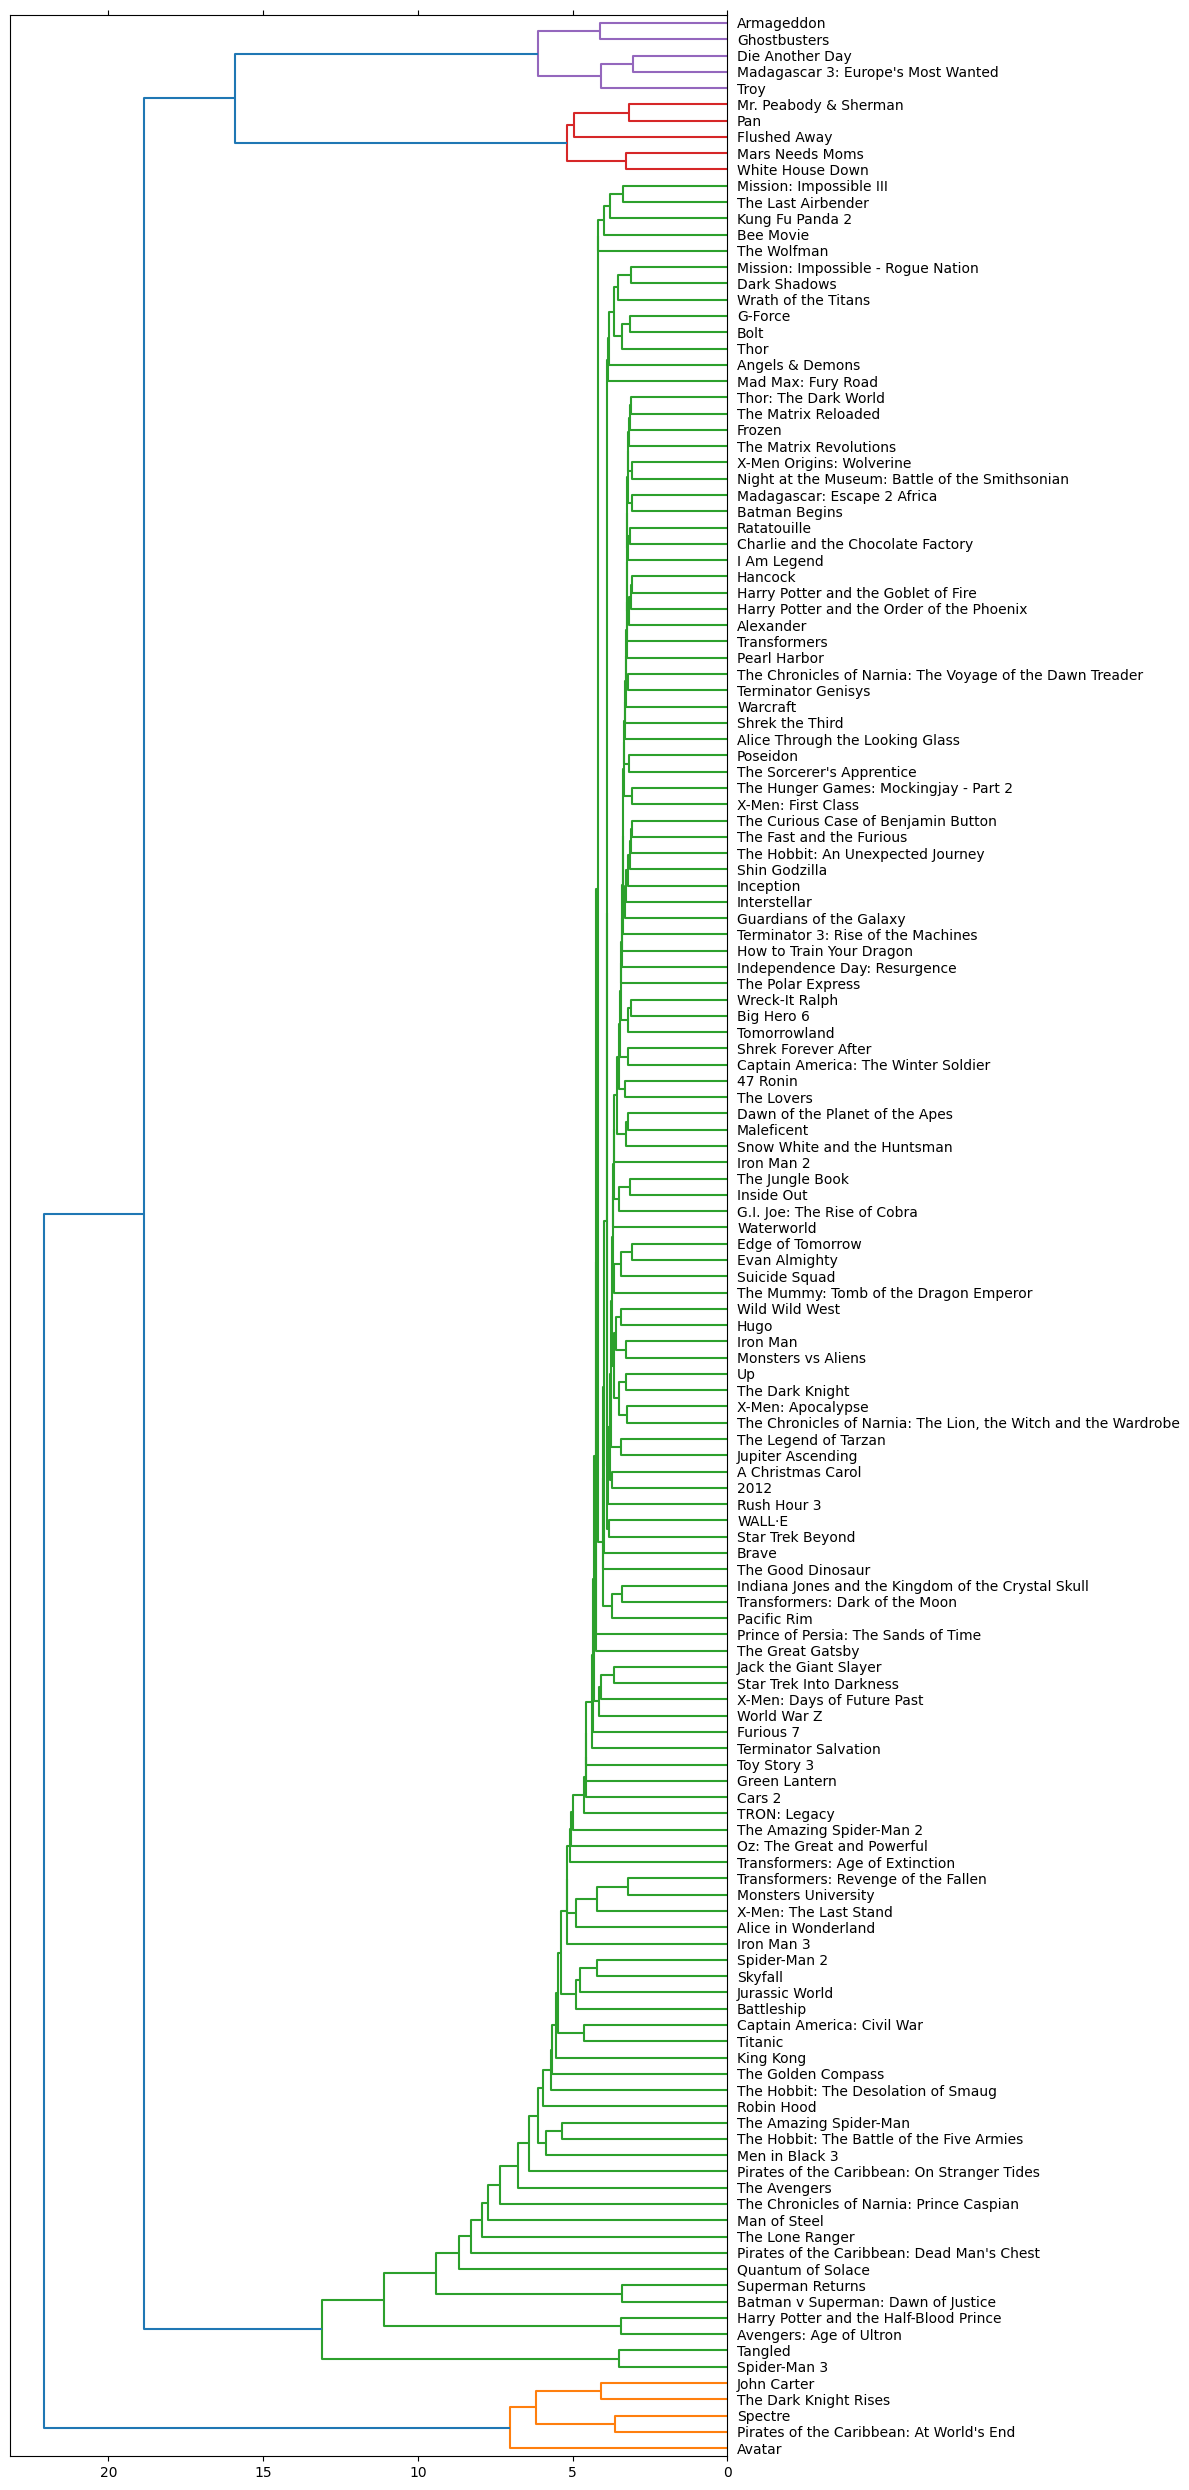

In [25]:
plot_hierarchical_clusters(linkage_matrix,
                           p = 150,
                           movie_data = df,
                           figure_size=(12,25))

**Based on this dendrogram, what are some interesting observations about the way movies have been grouped together in terms of genre, sub-genre or even sub-sub genres. Provide some examples of movies that could fit into these different levels of genre!**

Seeing exactly how close all of the movies are is interesting, but it makes me curious, how are movies like "Toy Story 3" is so closely correlated to "Terminator" and other movies like it? I'm also very surprised by the orange group. What makes "The Dark Night Rises" so different from all of the other batman movies? Same with the "Pirates of the Carribean."

**Of the three methods of clustering, did you feel any of these methods did the best job in grouping together movies?**

It's hard for me because I don't know a lot of the movies to make a good judgement. However, I liked the smaller clusters that the kmeans clustering produced, and I feel like it could be implemented into a product because the smaller clusters don't necessarily need a human to label the clusters. I think the most surprising thing I noticed with all of these movies was that just because I wouldn't group them together because their intended audience is very different, that doesn't necessarily mean that the movies are super different.